In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import EdgeCNN
from pathlib import Path
from tqdm import tqdm
import polars as pl
from gnn_example.graphdataset import GraphDataset
import numpy as np
import time
import os
from pathlib import Path
from bayes_opt import BayesianOptimization
import bayes_opt.acquisition as acq
import json
from pprint import pprint

DATA_DIR = Path("gnn_example") / "data"
TEST_PARQUET_FILE = DATA_DIR /  "test_sequences.parquet"

In [2]:
with open("gnn_example/outputs/02/results.json", "r") as f:
    results = json.load(f)



def loss_fn(output, target):
    clipped_target = torch.clip(target, min=0, max=1)
    mses = F.mse_loss(output, clipped_target, reduction='mean')
    return mses

def mae_fn(output, target):
    clipped_target = torch.clip(target, min=0, max=1)
    maes = F.l1_loss(output, clipped_target, reduction='mean')
    return maes


In [3]:
best_models = [
    ("4", 2), # (iteration, epoch)
    ("4b", 4),
    ("5", 10),
    ("5b", 2),
]

In [4]:
def pipeline(ITERATION_LOADED, EPOCH_LOADED):
    params = results[int(ITERATION_LOADED.strip("b"))]["params"]

    ALLOW_LOOPS = params["ALLOW_LOOPS"]
    EDGE_DISTANCE = params["EDGE_DISTANCE"]
    DROPOUT_RATE = params["DROPOUT_RATE"]
    N_TEST = 5000

    test_dataset = GraphDataset(TEST_PARQUET_FILE, edge_distance=EDGE_DISTANCE, allow_loops=ALLOW_LOOPS)
    test_dataloader = DataLoader(test_dataset[:N_TEST], batch_size=N_TEST, shuffle=False)
    model = EdgeCNN(4, 128, 4, 1, dropout=DROPOUT_RATE)
    model.load_state_dict(torch.load(f"gnn_example/outputs/02/Iteration_{ITERATION_LOADED}/model_epoch_{EPOCH_LOADED-1}.pt"))
    model.eval()

    with torch.no_grad():
        for batch in test_dataloader:
            out = model(batch.x, batch.edge_index)
            out = torch.squeeze(out)
            loss = loss_fn(out, batch.y)
            mae = mae_fn(out, batch.y)
            
            return f"Iteration {ITERATION_LOADED}, epoch {EPOCH_LOADED}: \n\t[Loss: {loss.item():.4f}, MAE: {mae.item():4f}]"

In [5]:
output_file = Path("gnn_example/outputs/03/results.txt")

if not output_file.exists():
    with open(output_file, "w") as f:
        for iteration, epoch in best_models:
            f.write(pipeline(iteration, epoch)+ "\n")

# Example of Prediction

In [7]:
import matplotlib.pyplot as plt

In [15]:
ITERATION_LOADED, EPOCH_LOADED = best_models[1]  # Example of loading the first model

params = results[int(ITERATION_LOADED.strip("b"))]["params"]

ALLOW_LOOPS = params["ALLOW_LOOPS"]
EDGE_DISTANCE = params["EDGE_DISTANCE"]
DROPOUT_RATE = params["DROPOUT_RATE"]
N_TEST = 5000

test_dataset = GraphDataset(TEST_PARQUET_FILE, edge_distance=EDGE_DISTANCE, allow_loops=ALLOW_LOOPS)

model = EdgeCNN(4, 128, 4, 1, dropout=DROPOUT_RATE)
model.load_state_dict(torch.load(f"gnn_example/outputs/02/Iteration_{ITERATION_LOADED}/model_epoch_{EPOCH_LOADED-1}.pt"))

model.eval()
with torch.no_grad():
    data_point = test_dataset[110]
    out = model(data_point.x, data_point.edge_index)
    out = torch.squeeze(out)

    # Sort out and y by y
    sorted_indices = torch.argsort(data_point.y)
    sorted_out = out[sorted_indices]
    sorted_y = data_point.y[sorted_indices]

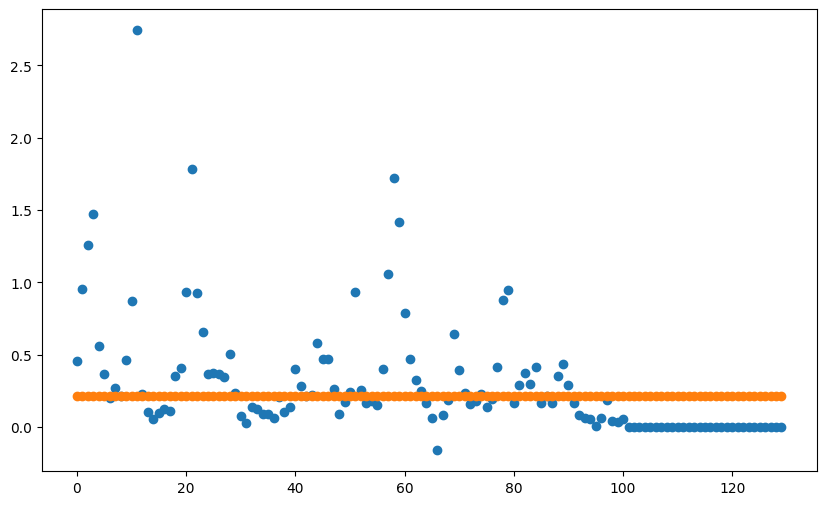

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_point.y, 'o')
ax.plot(out, 'o')